In [1]:
import argparse
import os
import gym
import numpy as np
import pickle
from tqdm import trange
import visdom
import math

import torch
from torch.distributions import uniform

#from ddpg import DDPG
#from normalized_actions import NormalizedActions
#from action_noise import NormalActionNoise
#from utils import save_model, vis_plot, load_model
#import ast

import itertools
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import copy
import random

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Text(3.68, -5.8, '  No extra\nnoise added')

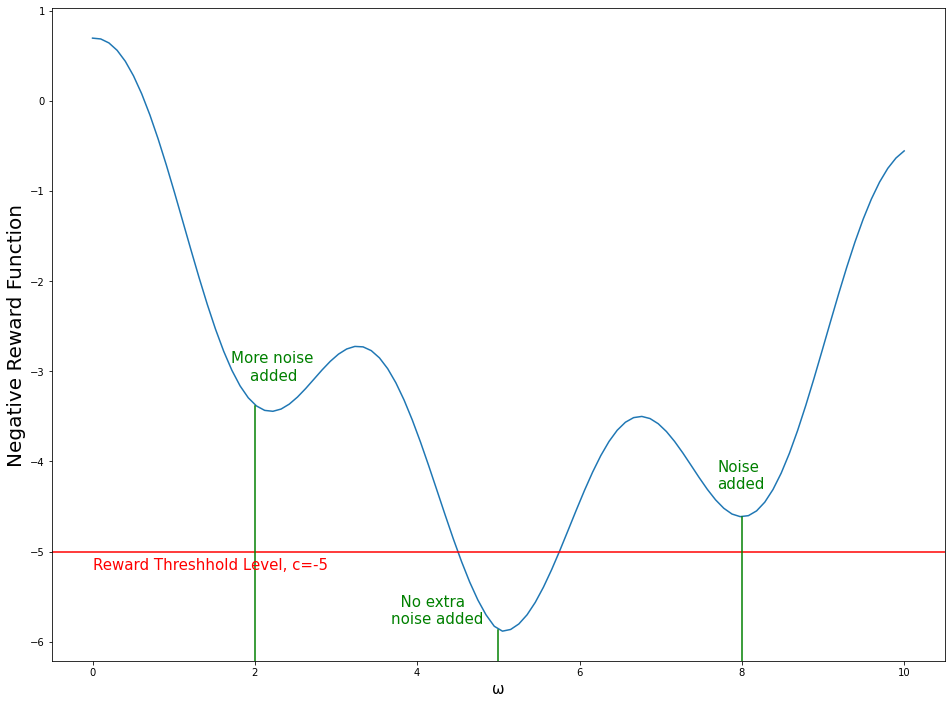

In [3]:
x = np.linspace(2,12,100)
y = -x-np.sin(2*x)+0.005*(np.power(x,3))-7+0.3*abs(x-7)
plt.figure(figsize=(16,12))
plt.plot(x-2,y+7.4)
plt.axhline(-5, color='r')
plt.axvline(x=8,ymin=0.22, ymax=0, color='g')
plt.axvline(x=2,ymin=0.39, ymax=0, color='g')
plt.axvline(x=5,ymin=0.047, ymax=0, color='g')
plt.ylabel("Negative Reward Function", fontsize=20)
plt.xlabel("ω", fontsize=15)
plt.annotate("Reward Threshhold Level, c=-5", (0,-5.2), fontsize=15, color='r')
plt.annotate("Noise\nadded", (7.7,-4.3), fontsize=15, color='g')
plt.annotate("More noise\n    added", (1.7,-3.1), fontsize=15, color='g')
plt.annotate("  No extra\nnoise added", (3.68,-5.8), fontsize=15, color='g')

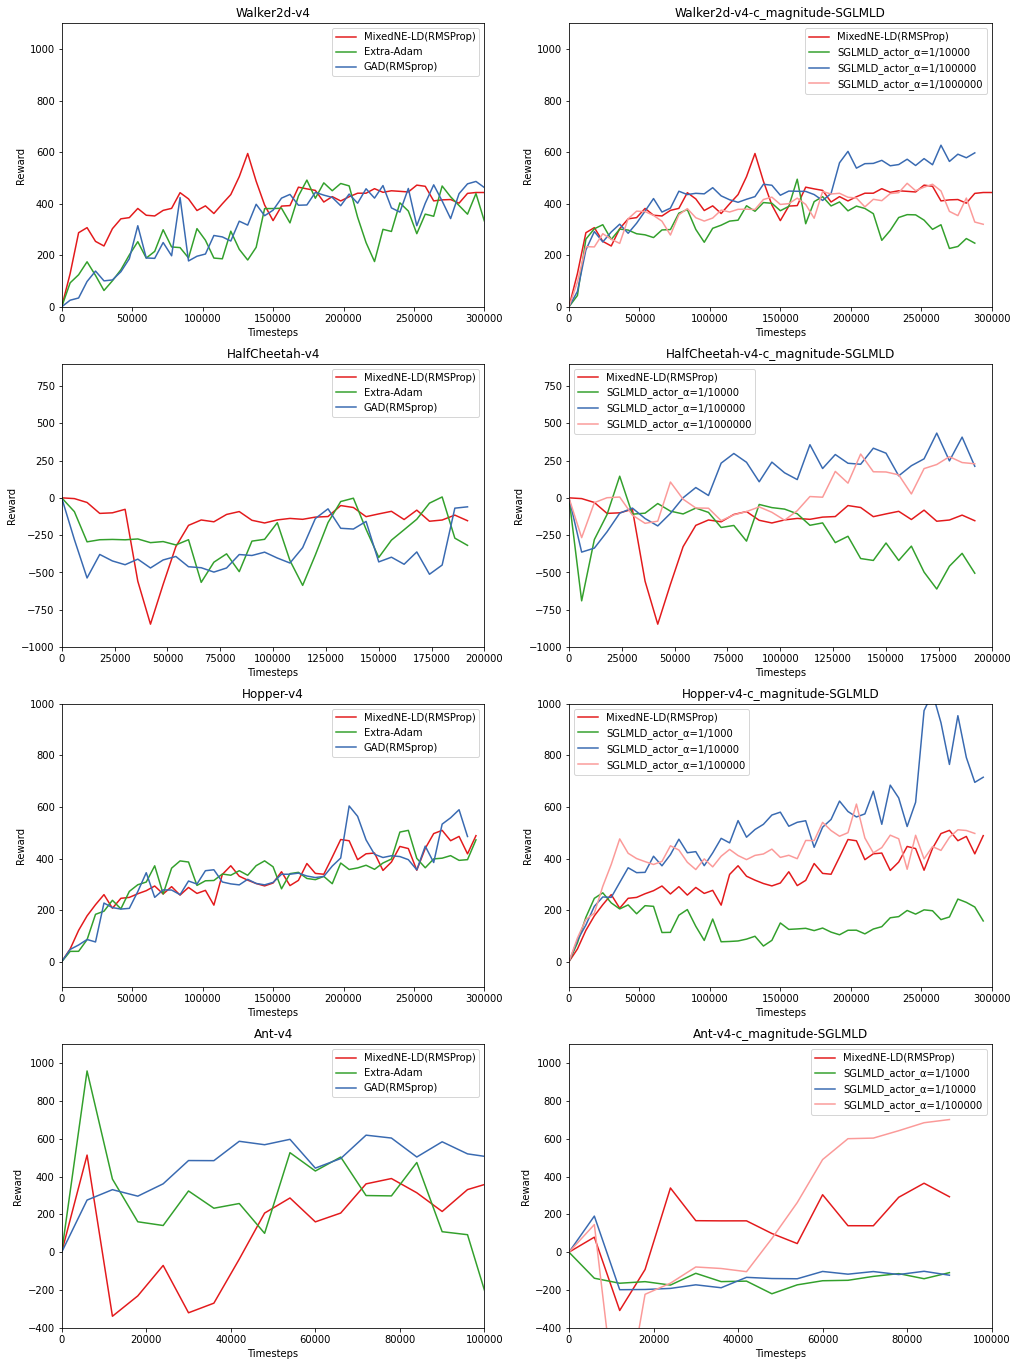

In [6]:
# Figure 2: Varying α, f(x) = x, only minimizing actor (1/2)


environments = ["Walker2d-v4", "Walker2d-v4-c_magnitude-SGLMLD",# "Walker2d-v4-arctan-c_magnitude-SGLMLD", "Walker2d-v4-squared-c_magnitude-SGLMLD", 
                "HalfCheetah-v4",  "HalfCheetah-v4-c_magnitude-SGLMLD",#, "HalfCheetah-v4-arctan-c_magnitude-SGLMLD", "HalfCheetah-v4-squared-c_magnitude-SGLMLD"]#,
                "Hopper-v4", "Hopper-v4-c_magnitude-SGLMLD",# "Hopper-v4-arctan-c_magnitude-SGLMLD", "Hopper-v4-squared-c_magnitude-SGLMLD",
                "Ant-v4", "Ant-v4-c_magnitude-SGLMLD"]#, "Ant-v4-arctan-c_magnitude-SGLMLD", "Ant-v4-squared-c_magnitude-SGLMLD", 
                # "Swimmer-v4", "Swimmer-v4-c_magnitude-SGLMLD",# "Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                # "Reacher-v4", "Reacher-v4-c_magnitude-SGLMLD",# "Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD", 
                # "Humanoid-v4", "Humanoid-v4-c_magnitude-SGLMLD",# "Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                # "InvertedPendulum-v4", "InvertedPendulum-v4-c_magnitude-SGLMLD"]# "InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
                
tests = {}
#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["HalfCheetah-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
tests["Walker2d-v4-c_magnitude-SGLMLD"]    = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'ExtraAdam/action_noise_0.2', 'RMSprop/action_noise_0.4']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'ExtraAdam__action_noise_0.3', 'RMSprop__action_noise_0.2']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.1']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Humanoid-v4"] = [ 'SGLD_thermal_0.0001/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'RMSprop/no_noise']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'RMSprop/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_actor_c100', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000']#, 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'RMSprop/action_noise_0.4']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_min/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            ax.set_ylim([-100, 1000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
    
        idx += 1  



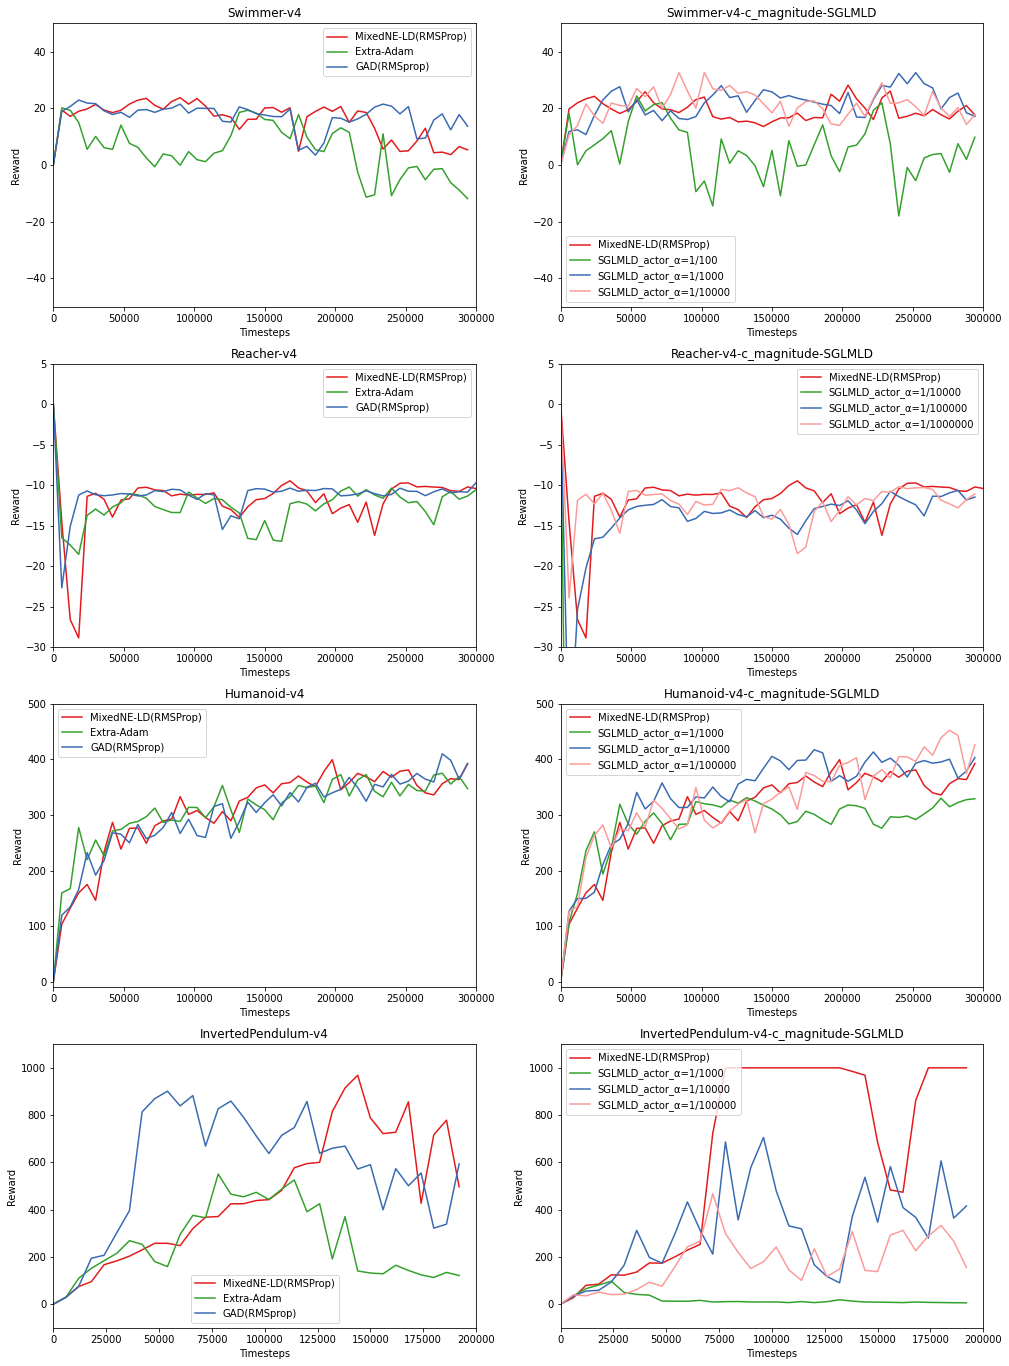

In [7]:
# Figure 2: Varying α, f(x) = x, only minimizing actor (2/2)


# environments = ["Walker2d-v4", "Walker2d-v4-c_magnitude-SGLMLD",# "Walker2d-v4-arctan-c_magnitude-SGLMLD", "Walker2d-v4-squared-c_magnitude-SGLMLD", 
#                 "HalfCheetah-v4",  "HalfCheetah-v4-c_magnitude-SGLMLD",#, "HalfCheetah-v4-arctan-c_magnitude-SGLMLD", "HalfCheetah-v4-squared-c_magnitude-SGLMLD"]#,
#                 "Hopper-v4", "Hopper-v4-c_magnitude-SGLMLD",# "Hopper-v4-arctan-c_magnitude-SGLMLD", "Hopper-v4-squared-c_magnitude-SGLMLD",
#                 "Ant-v4", "Ant-v4-c_magnitude-SGLMLD"#, "Ant-v4-arctan-c_magnitude-SGLMLD", "Ant-v4-squared-c_magnitude-SGLMLD", 
environments =                ["Swimmer-v4", "Swimmer-v4-c_magnitude-SGLMLD",# "Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                "Reacher-v4", "Reacher-v4-c_magnitude-SGLMLD",# "Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD", 
                "Humanoid-v4", "Humanoid-v4-c_magnitude-SGLMLD",# "Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                "InvertedPendulum-v4", "InvertedPendulum-v4-c_magnitude-SGLMLD"]# "InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
                
tests = {}
#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["HalfCheetah-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
tests["Walker2d-v4-c_magnitude-SGLMLD"]    = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'ExtraAdam/action_noise_0.2', 'RMSprop/action_noise_0.4']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000'] #, 'SGLMLD_actor_c1000'
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'ExtraAdam__action_noise_0.3', 'RMSprop__action_noise_0.2']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.1']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Humanoid-v4"] = [ 'SGLD_thermal_0.0001/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'RMSprop/no_noise']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'RMSprop/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_actor_c100', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000']#, 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'RMSprop/action_noise_0.4']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ["SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ["SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_min/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            ax.set_ylim([-100, 1000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
    
        idx += 1  



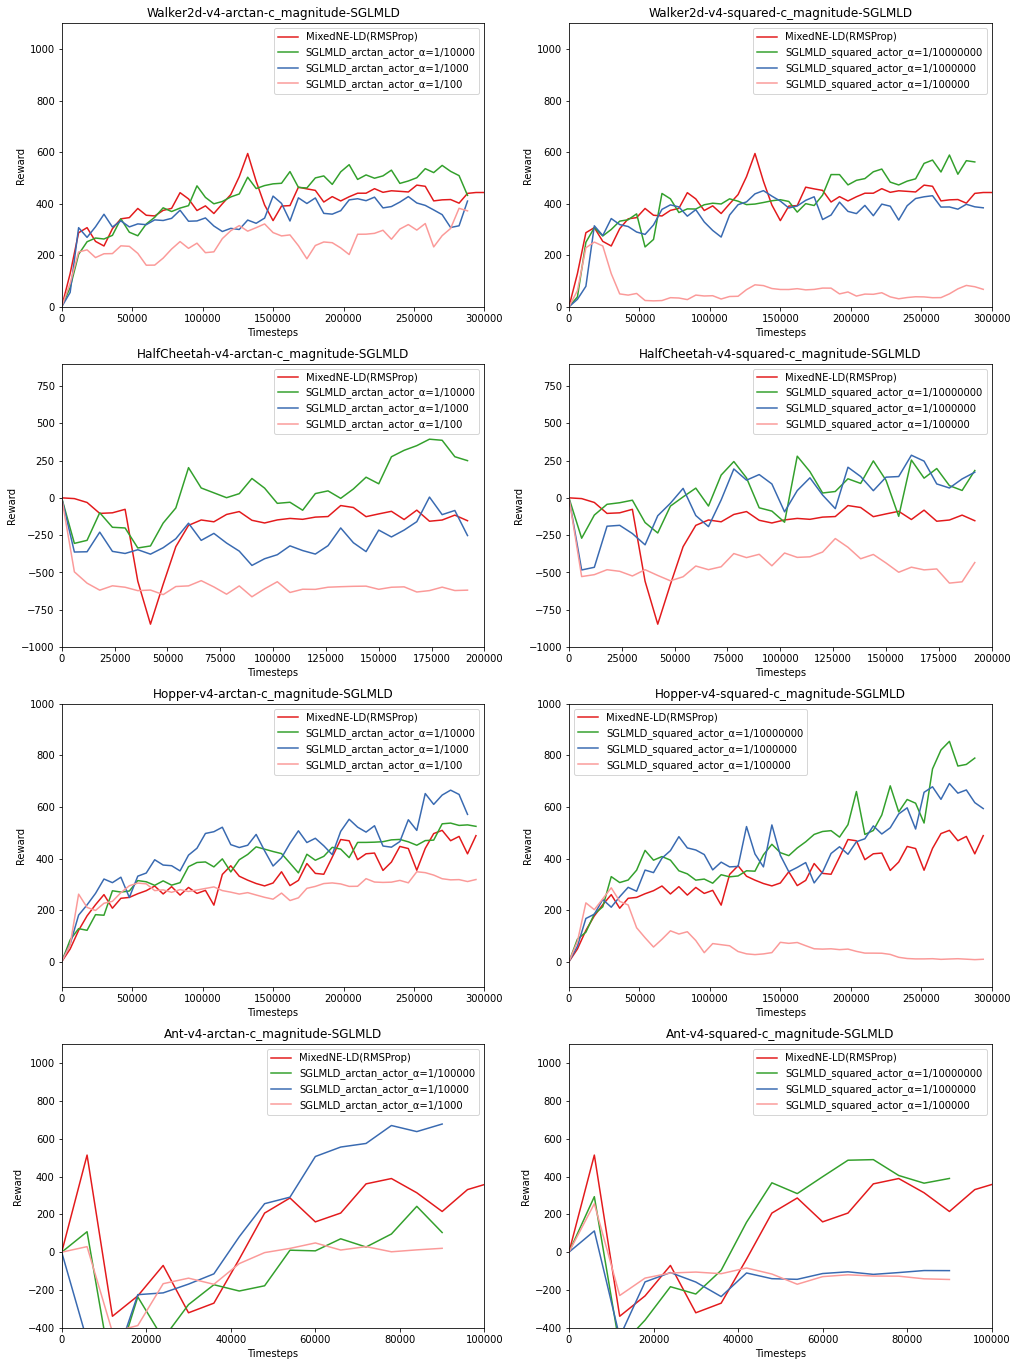

In [5]:
# Figure 2: Varying α, f(x) = arctan(x) and square(x), only minimizing actor (1/2)


environments = ["Walker2d-v4-arctan-c_magnitude-SGLMLD", "Walker2d-v4-squared-c_magnitude-SGLMLD", 
                "HalfCheetah-v4-arctan-c_magnitude-SGLMLD", "HalfCheetah-v4-squared-c_magnitude-SGLMLD",
                "Hopper-v4-arctan-c_magnitude-SGLMLD", "Hopper-v4-squared-c_magnitude-SGLMLD",
                "Ant-v4-arctan-c_magnitude-SGLMLD", "Ant-v4-squared-c_magnitude-SGLMLD"]
                # "Swimmer-v4", "Swimmer-v4-c_magnitude-SGLMLD",# "Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                # "Reacher-v4", "Reacher-v4-c_magnitude-SGLMLD",# "Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD", 
                # "Humanoid-v4", "Humanoid-v4-c_magnitude-SGLMLD",# "Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                # "InvertedPendulum-v4", "InvertedPendulum-v4-c_magnitude-SGLMLD"]# "InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
                
tests = {}
#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
tests["Walker2d-v4-c_magnitude-SGLMLD"]    = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'ExtraAdam/action_noise_0.2', 'RMSprop/action_noise_0.4']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'ExtraAdam__action_noise_0.3', 'RMSprop__action_noise_0.2']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.1']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Humanoid-v4"] = [ 'SGLD_thermal_0.0001/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'RMSprop/no_noise']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'RMSprop/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_actor_c100', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000']#, 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'RMSprop/action_noise_0.4']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_min/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            ax.set_ylim([-100, 1000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
    
        idx += 1  



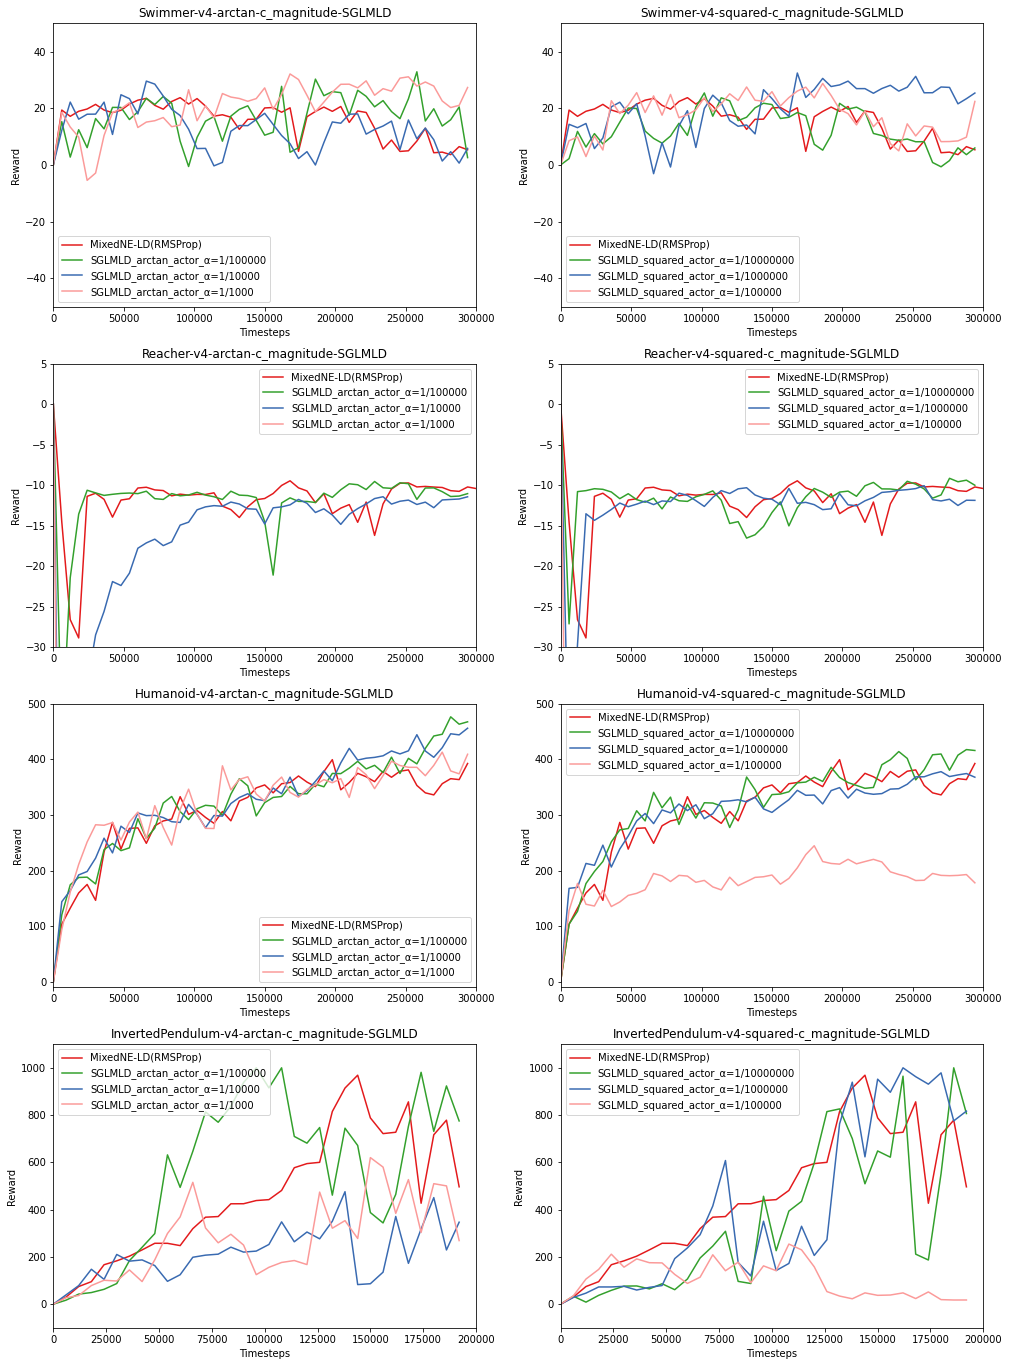

In [6]:
# Varying α, f(x) = arctan(x) and square(x), only minimizing actor (2/2)


environments = ["Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                "Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD", 
                "Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                "InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
                
tests = {}
#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
tests["Walker2d-v4-c_magnitude-SGLMLD"]    = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'ExtraAdam/action_noise_0.2', 'RMSprop/action_noise_0.4']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'ExtraAdam__action_noise_0.3', 'RMSprop__action_noise_0.2']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000", "SGLMLD_arctan_actor_c100"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.1']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Humanoid-v4"] = [ 'SGLD_thermal_0.0001/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'RMSprop/no_noise']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'RMSprop/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_actor_c100', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000']#, 'SGLMLD_actor_c100000', 'SGLMLD_actor_c1000000']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'RMSprop/action_noise_0.4']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_actor_c1000', 'SGLMLD_actor_c10000', 'SGLMLD_actor_c100000']#, 'SGLMLD_actor_c1000000']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_arctan_actor_c100000", "SGLMLD_arctan_actor_c10000", "SGLMLD_arctan_actor_c1000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_squared_actor_c10000000", "SGLMLD_squared_actor_c1000000", "SGLMLD_squared_actor_c100000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_min/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            ax.set_ylim([-100, 1000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
    
        idx += 1  



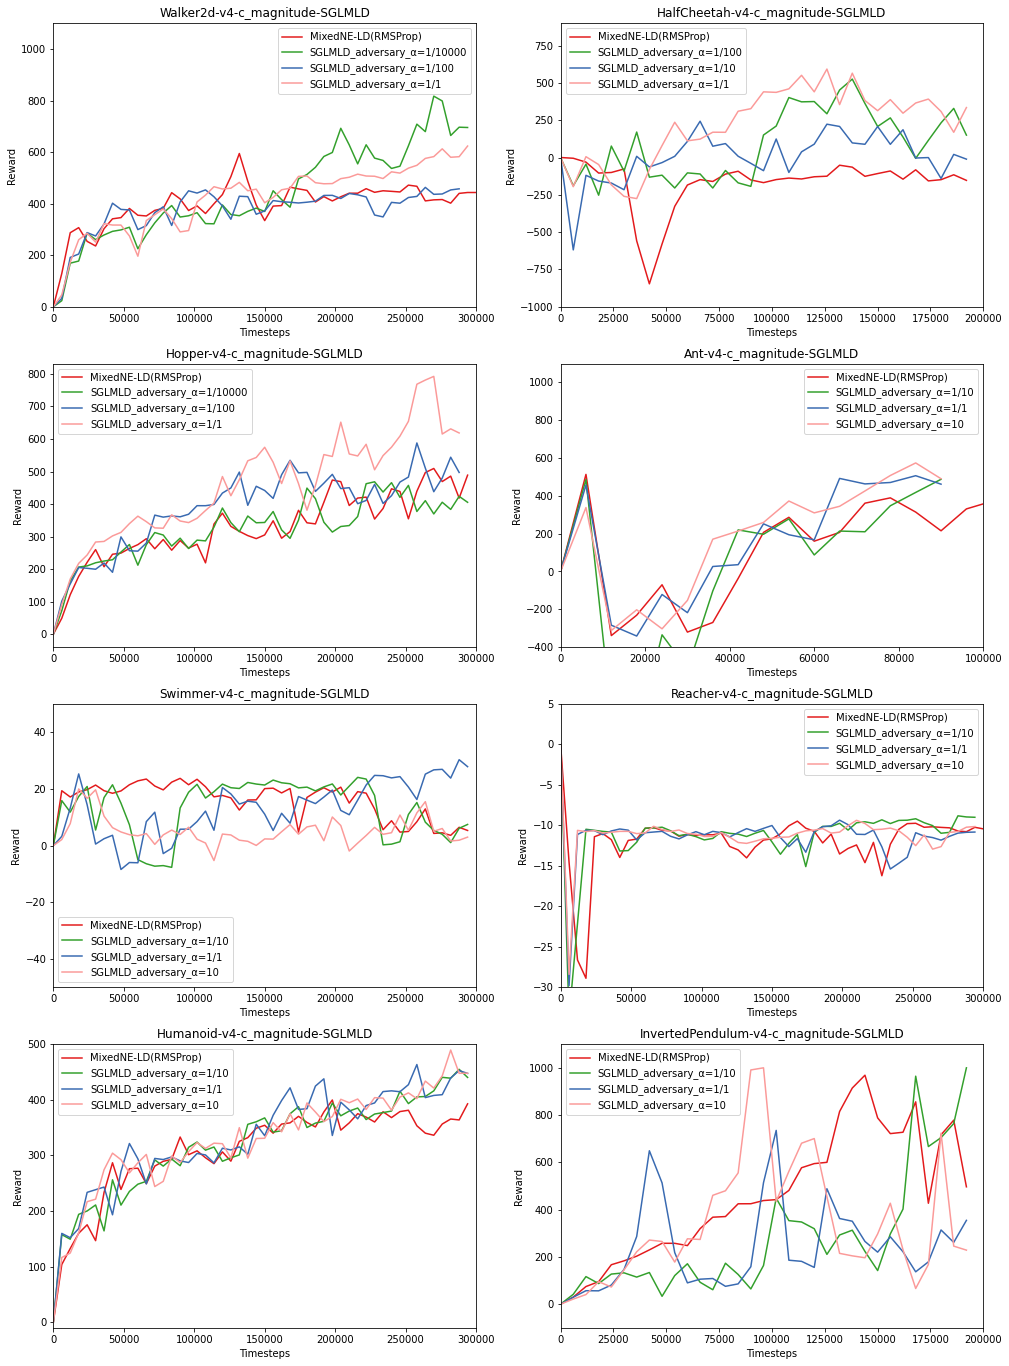

In [5]:
#Varying α, f(x) = x, only maximizing adversary

environments = ["Walker2d-v4-c_magnitude-SGLMLD",# "Walker2d-v4-arctan-c_magnitude-SGLMLD",  "Walker2d-v4-squared-c_magnitude-SGLMLD",
                "HalfCheetah-v4-c_magnitude-SGLMLD",# "HalfCheetah-v4-arctan-c_magnitude-SGLMLD",  "HalfCheetah-v4-squared-c_magnitude-SGLMLD",
                "Hopper-v4-c_magnitude-SGLMLD",# "Hopper-v4-arctan-c_magnitude-SGLMLD", "Hopper-v4-squared-c_magnitude-SGLMLD",
                "Ant-v4-c_magnitude-SGLMLD",# "Ant-v4-arctan-c_magnitude-SGLMLD", "Ant-v4-squared-c_magnitude-SGLMLD",
                "Swimmer-v4-c_magnitude-SGLMLD",#"Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                "Reacher-v4-c_magnitude-SGLMLD",#"Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD",
                "Humanoid-v4-c_magnitude-SGLMLD",#"Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                "InvertedPendulum-v4-c_magnitude-SGLMLD"]#,"InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
tests = {}
tests["blank"] = []

#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1']
#tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.3']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'RMSprop__action_noise_0.1', 'ExtraAdam__action_noise_0.01']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Humanoid-v4"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'RMSprop/no_noise', 'ExtraAdam/action_noise_0.01']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_max/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            if "_ct" in exp:
                l = exp.replace("_ct", "_α=")
            else:
                l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            #ax.set_ylim([-100, 2000])
            ax.set_xlim([0, 300000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
        #ax.fill_between(x, (y_avg)-(y_std), (y_avg)+(y_std), facecolor=colors[idx], alpha=0.4, interpolate=True)

    
        idx += 1  



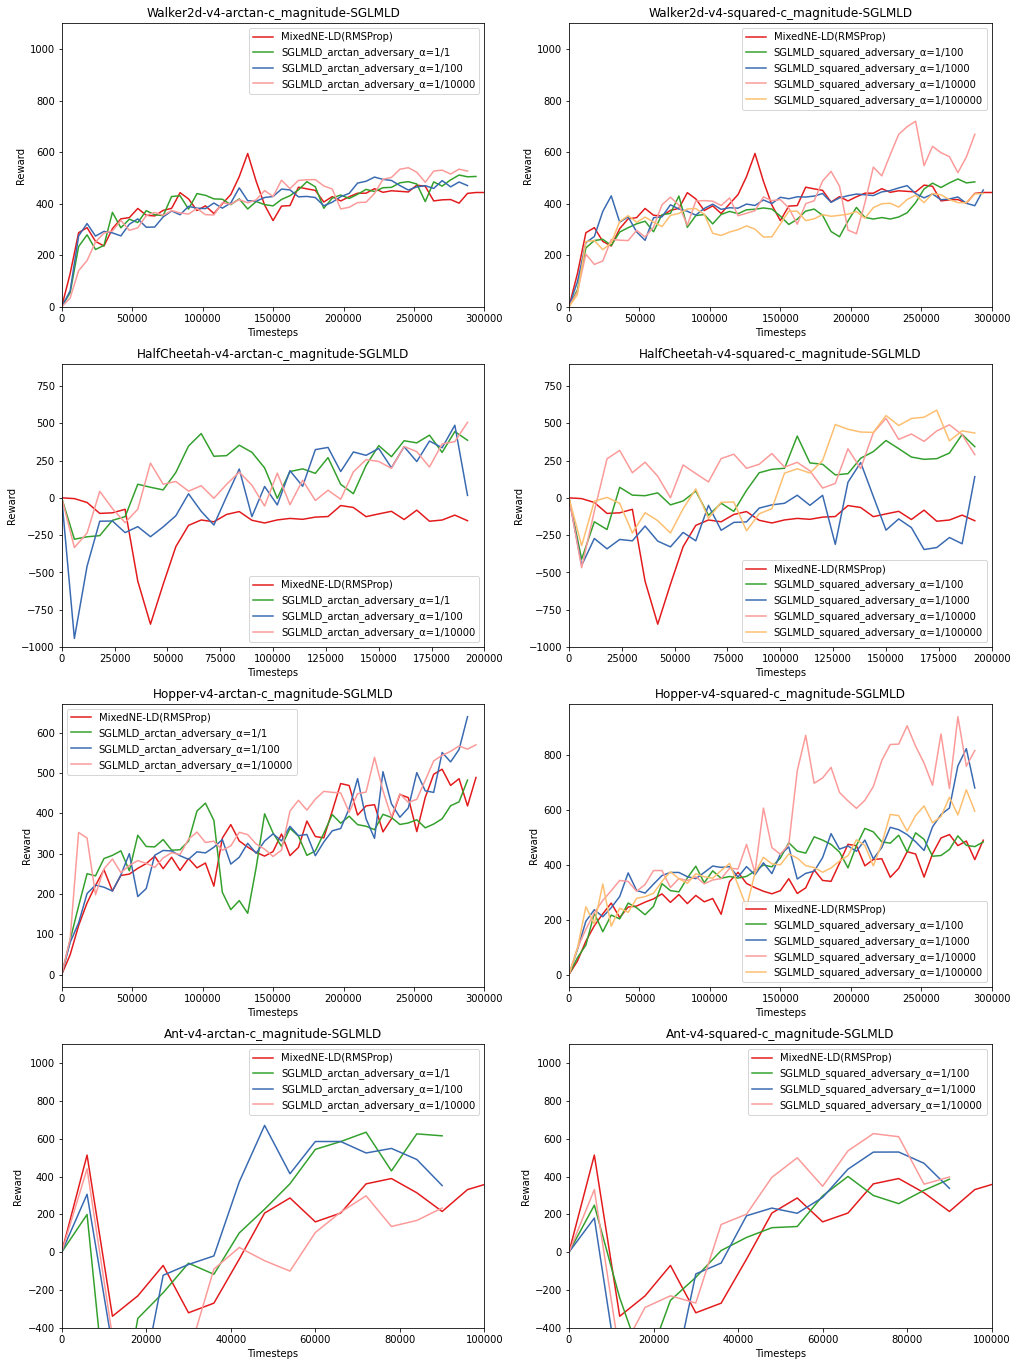

In [6]:
# Varying α, f(x) = arctan(x) and square(x), only maximizing adversary (1/2)

environments = ["Walker2d-v4-arctan-c_magnitude-SGLMLD",  "Walker2d-v4-squared-c_magnitude-SGLMLD",
                "HalfCheetah-v4-arctan-c_magnitude-SGLMLD",  "HalfCheetah-v4-squared-c_magnitude-SGLMLD",
                "Hopper-v4-arctan-c_magnitude-SGLMLD", "Hopper-v4-squared-c_magnitude-SGLMLD",
                "Ant-v4-arctan-c_magnitude-SGLMLD", "Ant-v4-squared-c_magnitude-SGLMLD"]
                #"Swimmer-v4-c_magnitude-SGLMLD",#"Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                #"Reacher-v4-c_magnitude-SGLMLD",#"Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD",
                #"Humanoid-v4-c_magnitude-SGLMLD",#"Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                #"InvertedPendulum-v4-c_magnitude-SGLMLD"]#,"InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
tests = {}
tests["blank"] = []

#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1']
#tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.3']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'RMSprop__action_noise_0.1', 'ExtraAdam__action_noise_0.01']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Humanoid-v4"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'RMSprop/no_noise', 'ExtraAdam/action_noise_0.01']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_max/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            if "_ct" in exp:
                l = exp.replace("_ct", "_α=")
            else:
                l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            #ax.set_ylim([-100, 2000])
            ax.set_xlim([0, 300000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
        #ax.fill_between(x, (y_avg)-(y_std), (y_avg)+(y_std), facecolor=colors[idx], alpha=0.4, interpolate=True)

    
        idx += 1  



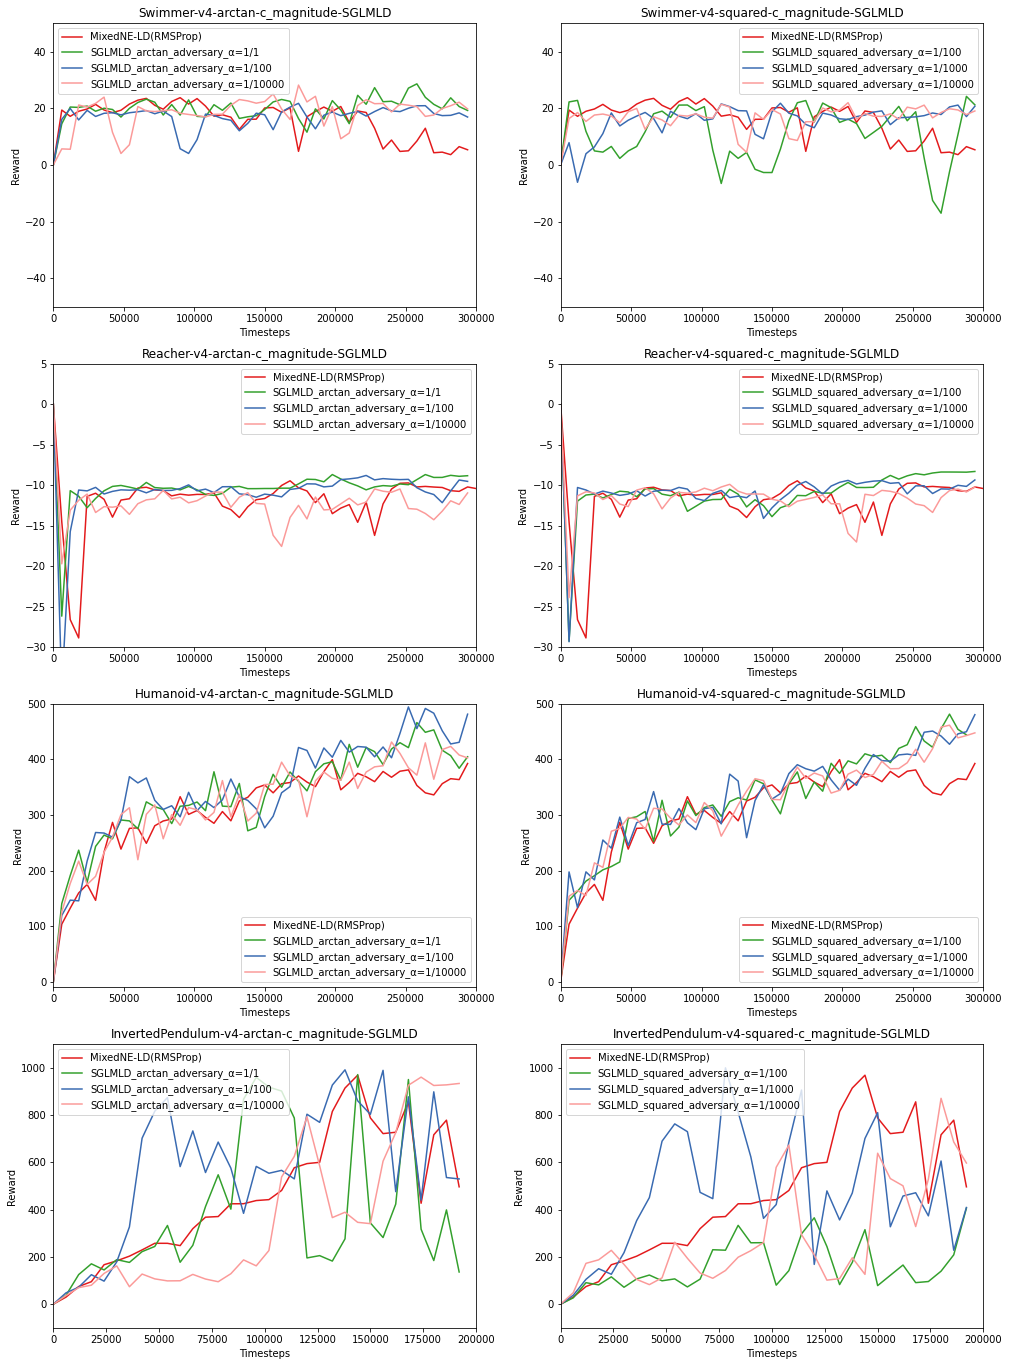

In [7]:
# Varying α, f(x) = arctan(x) and square(x), only maximizing adversary (2/2)

environments = ["Swimmer-v4-arctan-c_magnitude-SGLMLD", "Swimmer-v4-squared-c_magnitude-SGLMLD",
                "Reacher-v4-arctan-c_magnitude-SGLMLD", "Reacher-v4-squared-c_magnitude-SGLMLD",
                "Humanoid-v4-arctan-c_magnitude-SGLMLD", "Humanoid-v4-squared-c_magnitude-SGLMLD",
                "InvertedPendulum-v4-arctan-c_magnitude-SGLMLD", "InvertedPendulum-v4-squared-c_magnitude-SGLMLD"]
tests = {}
tests["blank"] = []

#tests["HalfCheetah-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.01', 'SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_actor_c10000']
tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1']
#tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["HalfCheetah-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["HalfCheetah-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Walker2d-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Walker2d-v4-fixed_c-SGLMLD"] = ['SGLMLD_actor_fixed_c-0', 'SGLMLD_actor_fixed_c-50', 'SGLMLD_actor_fixed_c-100', 'SGLMLD_actor_fixed_c-150', 'SGLMLD_actor_fixed_c-200']
tests["Walker2d-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Hopper-v4"] = ['SGLD_thermal_0.001__action_noise_0.2', 'RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.3']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c100000', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10', 'SGLMLD_adversary_ct10000']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_adversary_c10000','SGLMLD_adversary_c100', 'SGLMLD_adversary_c1']
#tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLMLD_adversary_c10']
tests["Hopper-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Hopper-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000", "SGLMLD_squared_adversary_c100000"]

tests["Reacher-v4"] = ['SGLD_thermal_0.001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2']
tests["Reacher-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Reacher-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Reacher-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["InvertedPendulum-v4"] = ['SGLD__thermal_0.001_action_noise_0.01', 'RMSprop__action_noise_0.1', 'ExtraAdam__action_noise_0.01']
tests["InvertedPendulum-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["InvertedPendulum-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["InvertedPendulum-v4-squared-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.001_action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Humanoid-v4"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'RMSprop/no_noise', 'ExtraAdam/action_noise_0.01']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Humanoid-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Humanoid-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Swimmer-v4"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4']
tests["Swimmer-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Swimmer-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Swimmer-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_1e-05/action_noise_0.4', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]

tests["Ant-v4"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01']
tests["Ant-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', 'SGLMLD_adversary_c10', 'SGLMLD_adversary_c1', 'SGLMLD_adversary_ct10']
tests["Ant-v4-arctan-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_arctan_adversary_c1", "SGLMLD_arctan_adversary_c100", "SGLMLD_arctan_adversary_c10000"]
tests["Ant-v4-squared-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.2', "SGLMLD_squared_adversary_c100", "SGLMLD_squared_adversary_c1000", "SGLMLD_squared_adversary_c10000"]



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_max/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            if "_ct" in exp:
                l = exp.replace("_ct", "_α=")
            else:
                l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            #ax.set_ylim([-100, 2000])
            ax.set_xlim([0, 300000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
        #ax.fill_between(x, (y_avg)-(y_std), (y_avg)+(y_std), facecolor=colors[idx], alpha=0.4, interpolate=True)

    
        idx += 1  



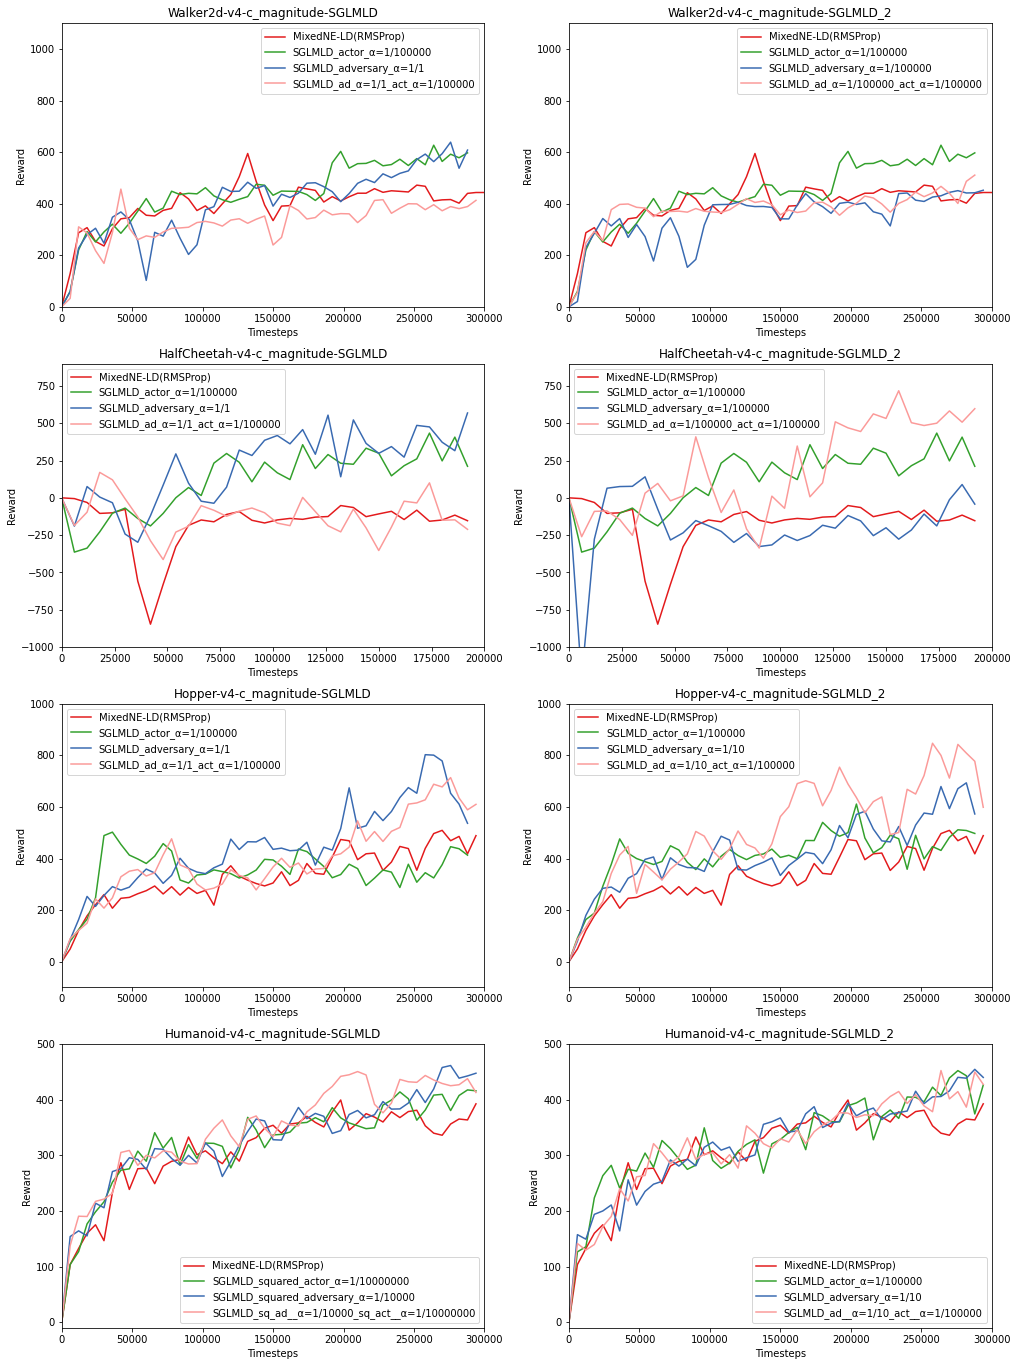

In [12]:
environments = ["Walker2d-v4", "Walker2d-v4-c_magnitude-SGLMLD", "Walker2d-v4-arctan-c_magnitude-SGLMLD", "blank",
                "HalfCheetah-v4", "HalfCheetah-v4-c_magnitude-SGLMLD", "HalfCheeetah-v4-arctan-c_magnitude-SGLMLD", "blank",
                "Hopper-v4", "Hopper-v4-c_magnitude-SGLMLD", "Hopper-v4-arctan-c_magnitude-SGLMLD", "blank"]

environments = ["Walker2d-v4-c_magnitude-SGLMLD", "Walker2d-v4-c_magnitude-SGLMLD_2",
                "HalfCheetah-v4-c_magnitude-SGLMLD", "HalfCheetah-v4-c_magnitude-SGLMLD_2",
                "Hopper-v4-c_magnitude-SGLMLD", "Hopper-v4-c_magnitude-SGLMLD_2",
                "Humanoid-v4-c_magnitude-SGLMLD", "Humanoid-v4-c_magnitude-SGLMLD_2"]
tests = {}
tests["blank"] = []

tests["Walker2d-v4"] = ['SGLD__thermal_0.01_action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'RMSprop__no_noise']
tests["Walker2d-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c1', 'SGLMLD_ad_c1_act_c100000']
tests["Walker2d-v4-c_magnitude-SGLMLD_2"] = ['SGLD__thermal_0.01_action_noise_0.01', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c100000', 'SGLMLD_ad_c100000_act_c100000']

tests["HalfCheetah-v4"] = ['SGLD__thermal_0.01_no_noise', 'ExtraAdam__action_noise_0.01', 'RMSprop__action_noise_0.2']
tests["HalfCheetah-v4-c_magnitude-SGLMLD"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c1', 'SGLMLD_ad_c1_act_c100000']
tests["HalfCheetah-v4-c_magnitude-SGLMLD_2"] = ['SGLD__thermal_0.01_no_noise', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c100000', 'SGLMLD_ad_c100000_act_c100000']

tests["Hopper-v4"] = ['RMSprop__action_noise_0.2', 'ExtraAdam__action_noise_0.3', 'SGLD_thermal_0.001__action_noise_0.2']
tests["Hopper-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c1', 'SGLMLD_ad_c1_act_c100000']
tests["Hopper-v4-c_magnitude-SGLMLD_2"] = ['SGLD_thermal_0.001__action_noise_0.2', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c10', 'SGLMLD_ad_c10_act_c100000']

tests["Humanoid-v4"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'ExtraAdam__action_noise_0.3', 'SGLD_thermal_0.001__action_noise_0.2']
tests["Humanoid-v4-c_magnitude-SGLMLD"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_squared_actor_c10000000', 'SGLMLD_squared_adversary_c10000', 'SGLMLD_sq_ad_α=10000_sq_act_α=10000000']
tests["Humanoid-v4-c_magnitude-SGLMLD_2"] = ['SGLD_thermal_0.0001/action_noise_0.01', 'SGLMLD_actor_c100000', 'SGLMLD_adversary_c10', 'SGLMLD_ad_α=10_act_α=100000']



rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(25*cols/3, 12*rows/2))
env_num = -1
for env_name in environments:
    env_num += 1
    results_loc = os.path.split(os.getcwd())[0] + '/github Robust-Reinforc/mujoco_env_specific/my_test_archived/' + env_name
    results = {}
    for test in tests[env_name]:
        results[test] = {}
        seed_num = len(os.listdir(results_loc+"/"+test))
        for seed in range(seed_num):
            with open(results_loc + "/" + test + "/" + str(seed) + '/results', 'rb') as f:
                results[test][seed] = pickle.load(f)

    colors = ['#e31a1c', '#33a02c', '#396ab1', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6']
    window_size = 6000
    ax = axs.flatten()[env_num]
    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        reward = []    
        for seed in results[exp]:
            reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
        merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        elif 'SGLMLD' in exp:
            if "α" in exp:
                l = exp.replace("α=", "_α=1/")
            elif "_ct" in exp:
                l = exp.replace("_ct", "_α=")
            else:
                l = exp.replace("_c", "_α=1/")
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        ax.set_title(env_name)    
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward')
        ax.legend()
        ax.set_xlim([0, 300000])
        if "Walker" in env_name:
            ax.set_ylim([0,1100])
        if "HalfCheetah" in env_name:
            ax.set_ylim([-1000, 900])
            ax.set_xlim([0, 200000])
        if "Hopper" in env_name:
            ax.set_ylim([-100, 1000])
            ax.set_xlim([0, 300000])
        if "Ant" in env_name:
            ax.set_ylim([-400, 1100])
            ax.set_xlim([0, 100000])
        if "Swimmer" in env_name:
            ax.set_ylim([-50, 50])
        if "Reacher" in env_name:
            ax.set_ylim([-30, 5])
        if "Humanoid" in env_name:
            ax.set_ylim([-10, 500])
        if "InvertedPendulum" in env_name:
            ax.set_ylim([-100, 1100])
            ax.set_xlim([0, 200000])
        #ax.fill_between(x, (y_avg)-(y_std), (y_avg)+(y_std), facecolor=colors[idx], alpha=0.4, interpolate=True)

    
        idx += 1  

